In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 huggingface_hub matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 38.7 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import login
login()

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
model_name = "meta-llama/Llama-2-7b-chat-hf"

dataset_name = "Kishorereddy123/transformed_QA"

new_model = "Llama-2-7b-chat-finetune"


lora_r = 64

lora_alpha = 16

lora_dropout = 0.1


# bitsandbytes parameters

use_4bit = True

bnb_4bit_compute_dtype = "float16"

bnb_4bit_quant_type = "nf4"

use_nested_quant = False


# TrainingArguments parameters


# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"


num_train_epochs = 40

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

per_device_train_batch_size = 4

per_device_eval_batch_size = 4

gradient_accumulation_steps = 1

gradient_checkpointing = True

max_grad_norm = 0.3

learning_rate = 2e-4

weight_decay = 0.001

optim = "paged_adamw_32bit"

lr_scheduler_type = "cosine"

max_steps = -1

warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

save_steps = 0

logging_steps = 25


# SFT parameters


max_seq_length = None

packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [ ]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    use_auth_token=True,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="Question_Answer",
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/86 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/86 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,2.647600
50,1.638800
75,1.233200
100,1.007100
125,0.765700
150,0.586100
175,0.391400
200,0.308800
225,0.219000
250,0.179100


TrainOutput(global_step=880, training_loss=0.3112895287234675, metrics={'train_runtime': 621.954, 'train_samples_per_second': 5.531, 'train_steps_per_second': 1.415, 'total_flos': 1.094346646929408e+16, 'train_loss': 0.3112895287234675, 'epoch': 40.0})

In [ ]:
trainer.model.save_pretrained(new_model)
tokenizer.save_pretrained(new_model)

('Llama-2-7b-chat-finetune/tokenizer_config.json',
 'Llama-2-7b-chat-finetune/special_tokens_map.json',
 'Llama-2-7b-chat-finetune/tokenizer.model',
 'Llama-2-7b-chat-finetune/added_tokens.json',
 'Llama-2-7b-chat-finetune/tokenizer.json')

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt =   "How can we generate pseudorandom numbers using Python's random module?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=150)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] How can we generate pseudorandom numbers using Python's random module? [/INST] We can generate pseudorandom numbers using Python's random module by importing it and using functions such as `random()` and `randint()`. `random()` generates a random float between 0.0 and 1.0 (including 0.0 but not 1.0), while `randint(low, high)` generates a random integer between `low` and `high`, including both.  For example:  ```python random = random.random() print(random) randint = randint(1, 10) print(randint) ```  This will generate a random float between 


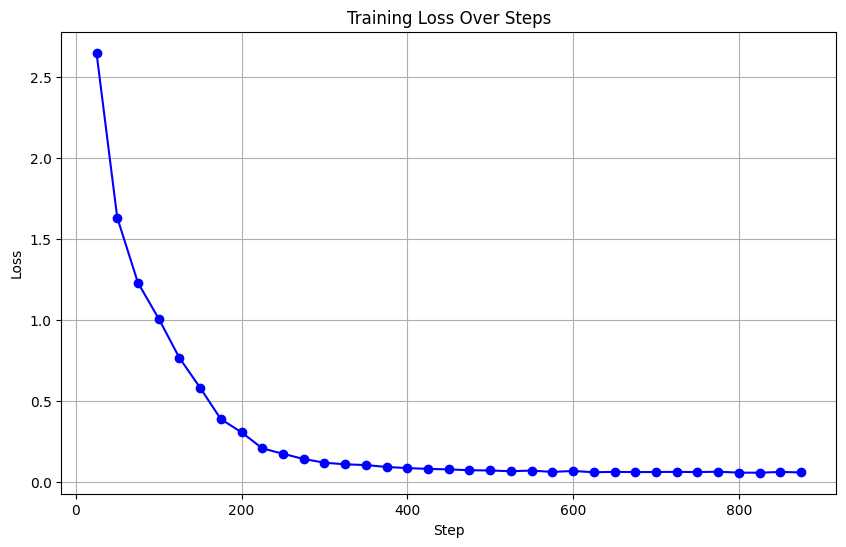

In [ ]:
import matplotlib.pyplot as plt
training_loss_history = trainer.state.log_history

steps = [log['step'] for log in training_loss_history]
training_losses = [log.get('loss', None) for log in training_loss_history]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, training_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


**Store New Llama2 Model (Llama-2-7b-chat-finetune)**

To store the new model we need to merge the weights from LoRA with the base model. Unfortunately, there is no straightforward way to do it: we need to reload the base model in FP16 precision and use the peft library to merge everything.
Clear the VRAM before merging

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()


20933

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

**Push the Model to Hugging Face**

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
model.push_to_hub("Kishorereddy123/llama2_finetuned", check_pr=True)

tokenizer.push_to_hub("Kishorereddy123/llama2_finetuned",check_pr=True)


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Kishorereddy123/llama2_finetuned/commit/e8717dbb6333dafd3d7467ff745ddb3b1daf6690', commit_message='Upload tokenizer', commit_description='', oid='e8717dbb6333dafd3d7467ff745ddb3b1daf6690', pr_url=None, pr_revision=None, pr_num=None)

**Evaluation of Fine-Tuned Model**


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/630 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/183 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/86 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38 [00:00<?, ? examples/s]

Input length of input_ids is 252, but `max_length` is set to 160. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 264, but `max_length` is set to 160. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 208, but `max_length` is set to 160. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 181, but `max_length` is set to 160. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 307, but `max_length` is set to 160. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 170, but `max_length` is set to 160. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 242, but `max_length` is set to 160. This can lead to

(True, False, False, False, False, False, False, False, False, False, False, False, True, False, True, True, False, False, True, False)
(1.0, 0.9955156950672646, 0.8020833333333333, 0.47619047619047616, 0.9206349206349206, 0.986046511627907, 0.7292817679558011, 0.6615384615384615, 0.8817204301075269, 0.6153846153846153, 0.9919354838709677, 0.296875, 1.0, 0.5544554455445544, 1.0, 1.0, 0.9140271493212669, 0.9276595744680851, 1.0, 0.7092198581560284)


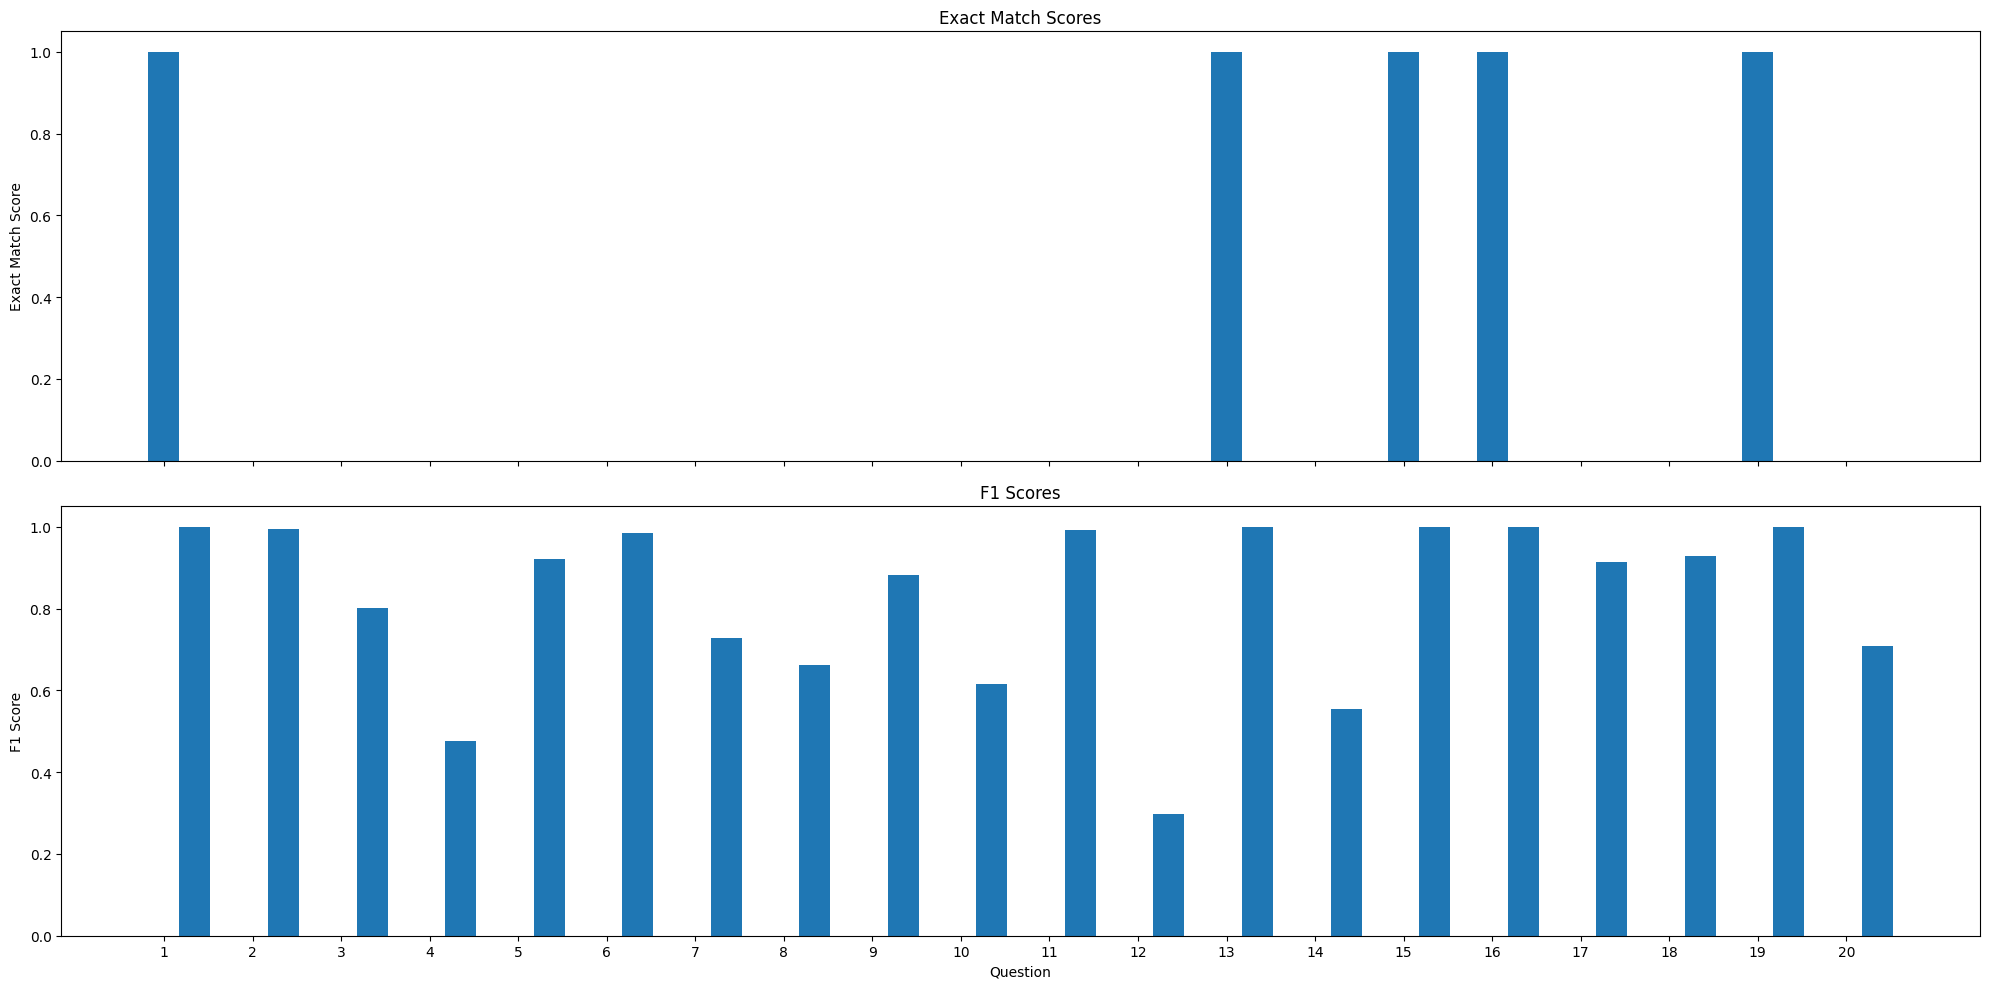

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import re
from collections import Counter
import torch
import matplotlib.pyplot as plt


def normalize_answer(s): # The function normalize_answer is defined with a single parameter s, which is the text string to be normalized.
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)  #This function uses a regular expression to find and replace the English articles "a", "an", and "the" with a space. The \b around the articles ensures that only whole words are matched (word boundaries), avoiding partial matches within larger words.

    def white_space_fix(text):
        return ' '.join(text.split()) #This removes extra spaces with in the string

    def remove_punctuation(text):
        return re.sub(r'[\W]', ' ', text) #this uses a regular expression to replace all non-word characters with a space

    def lower(text):
        return text.lower() #This converts all characters in the text to lowercase

    return white_space_fix(remove_articles(remove_punctuation(lower(s))))

def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common_tokens = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common_tokens.values()) # the total number of matching tokens between the prediction and the ground truth is summed up.
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens) #ratio of correctly predicted tokens to the total number of tokens in the prediction
    recall = 1.0 * num_same / len(ground_truth_tokens)  #ratio of correctly predicted tokens to the total number of tokens in the ground truth
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    return normalize_answer(prediction) == normalize_answer(ground_truth)

def generate_answer(question, model, tokenizer,temperature=0.3,top_k=10):
    """Generate an answer for a given question using the model."""
    inputs = tokenizer.encode(question, return_tensors="pt") #this will converts the question text into format that the model can understand and return as pytorch tensor.
    with torch.no_grad():
        outputs = model.generate(inputs, max_length=160, pad_token_id=tokenizer.eos_token_id,temperature=temperature,top_k = top_k)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

def evaluate_and_collect_metrics(dataset, model, tokenizer):
    question_metrics = []  # Store metrics for each question

    for item in dataset:
        question = item['Question_Answer']
        ground_truth = item['Question_Answer']
        prediction = generate_answer(question, model, tokenizer)

        exact_match = exact_match_score(prediction, ground_truth)
        f1 = f1_score(prediction, ground_truth)

        # Collect metrics along with the question for plotting
        question_metrics.append((question, exact_match, f1))

    return question_metrics

# Load the tokenizer and model from Hugging Face
model_name = "Kishorereddy123/llama2_finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Load the dataset
dataset = load_dataset("Kishorereddy123/accurate_QA", split="test")

# Evaluate the model
question_metrics = evaluate_and_collect_metrics(dataset, model, tokenizer)


def plot_question_scores(question_metrics):
    # Unpack the metrics
    questions, exact_matches, f1_scores = zip(*question_metrics)


    N = min(20, len(questions)) #plot up to 20 questions for readability
    exact_matches = exact_matches[:N]
    print(exact_matches)
    f1_scores = f1_scores[:N]
    print(f1_scores)

    x = range(N)  # Question indices
    width = 0.35  # Bar width

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

    # Plot Exact Match
    ax1.bar(x, exact_matches, width, label='Exact Match')
    ax1.set_ylabel('Exact Match Score')
    ax1.set_title('Exact Match Scores')

    # Plot F1 Score
    ax2.bar([p + width for p in x], f1_scores, width, label='F1 Score')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('F1 Scores')

    # Set common x-axis label and tick locations
    ax2.set_xticks(x)
    ax2.set_xticklabels(range(1, N + 1))
    ax2.set_xlabel('Question')

    plt.tight_layout()
    plt.show()

plot_question_scores(question_metrics)

In [ ]:
from google.colab import runtime
runtime.unassign()